In [1]:
"""
Introduction
    - Transpiler passes: circuit transformations. We want to combine them with each other
    - Which passes are chained together and in which order has a major effect on final outcome
    - Pass manager: determines the pipeline
        - Schedules the passes
        - Allows passes to communicate with each other by providing a shared space
    - Transpiler opens up the door for research into aggressive optimization of quantum circuits
    - We will look at:
        - Built-in passes
        - How to use the pass manager
        - How to develop a simple custom transpiler pass
            - First need to introduce the internal representation of quantum circuits in Qiskit
            - Directed Acyclic Graph (DAG)
            - Illustrate simple swap mapper pass: transforms an input circuit to be compatible with  a limited-connectivity quantum deviec
"""
from qiskit import *
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

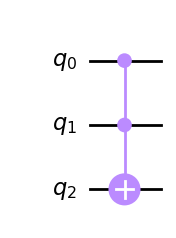

In [2]:
"""
PassManager object
"""
circ = QuantumCircuit(3)
circ.ccx(0,1,2)
circ.draw('mpl')

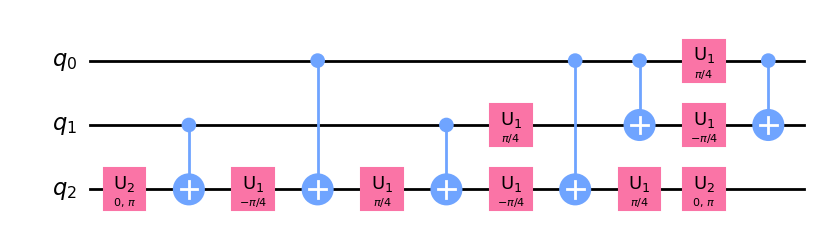

In [3]:
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u1','u2','u3','cx'])
pm = PassManager(pass_)
new_circ = pm.run(circ)
new_circ.draw('mpl')

In [4]:
from qiskit.transpiler import passes
[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ALAPSchedule',
 'ALAPScheduleAnalysis',
 'ASAPSchedule',
 'ASAPScheduleAnalysis',
 'AlignMeasures',
 'ApplyLayout',
 'BIPMapping',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckGateDirection',
 'CheckMap',
 'Collect1qRuns',
 'Collect2qBlocks',
 'CollectCliffords',
 'CollectLinearFunctions',
 'CollectMultiQBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'CommutativeInverseCancellation',
 'Commuting2qGateRouter',
 'ConsolidateBlocks',
 'ConstrainedReschedule',
 'ContainsInstruction',
 'ConvertConditionsToIfOps',
 'CountOps',
 'CountOpsLongestPath',
 'CrosstalkAdaptiveSchedule',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EchoRZXWeylDecomposition',
 'EnlargeWithAncilla',
 'Error',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'GatesInBasis',
 'HighLevelSynthesis',
 'HoareOptimizer',
 'InstructionDuratio

In [5]:
"""
Different Variants of the Same Pass
    - There can be apsses that do the same job, but in different ways
    - TrivialLayout, DenseLayout, and NoiseAdaptiveLayout
        - All choose a layout (binding of virtual qubits to physical qubits)
        - Use different algorithms and objectives
    - BasicSwap, LookaheadSwap, and StochasticSwap
        - All insert swaps to make the circuit compatible with the coupling map
        - Below, we show the swapper passes all applied to the same circuit
        - To transform it to match a linear chain topology
"""
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap

coupling = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6]]

circuit = QuantumCircuit(7)
circuit.h(3)
circuit.cx(0,6)
circuit.cx(6,0)
circuit.cx(0,1)
circuit.cx(3,1)
circuit.cx(3,0)

coupling_map = CouplingMap(couplinglist = coupling)

bs = BasicSwap(coupling_map = coupling_map)
pass_manager = PassManager(bs)
basic_circ = pass_manager.run(circuit)

ls = LookaheadSwap(coupling_map = coupling_map)
pass_manager = PassManager(ls)
lookahead_circ = pass_manager.run(circuit)

ss = StochasticSwap(coupling_map = coupling_map)
pass_manager = PassManager(ss)
stochastic_circ = pass_manager.run(circuit)

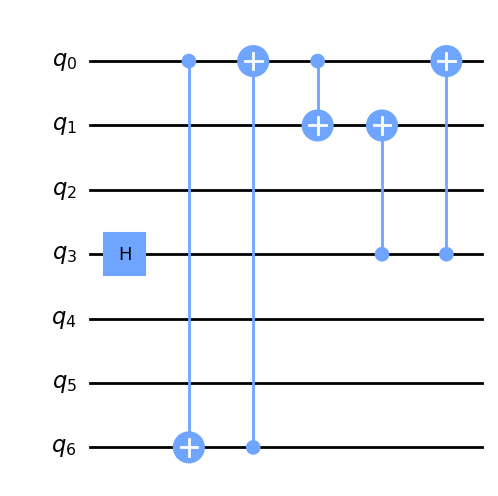

In [6]:
circuit.draw(output='mpl')

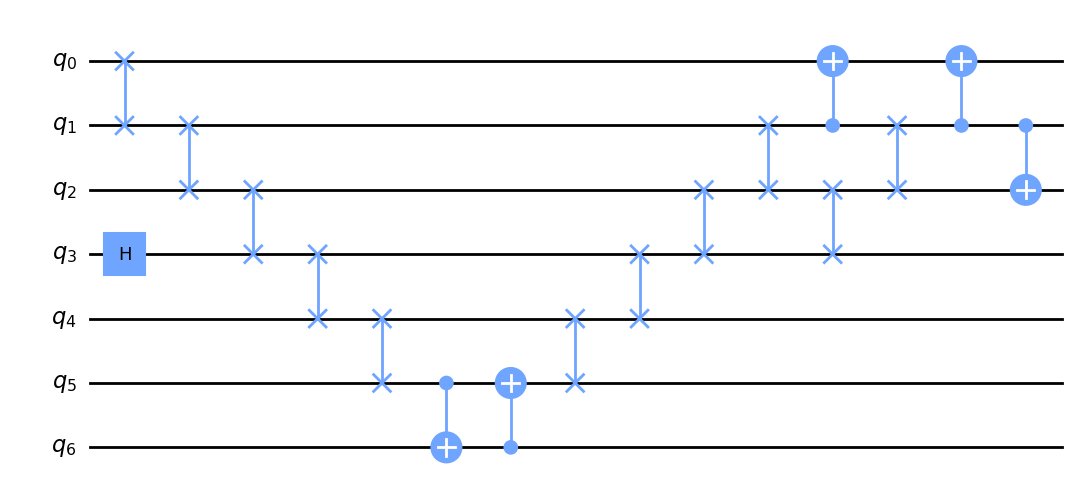

In [7]:
basic_circ.draw(output='mpl')

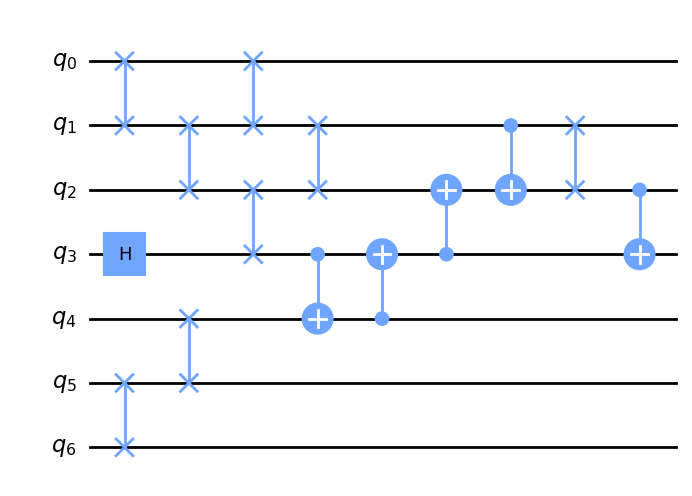

In [8]:
lookahead_circ.draw('mpl')

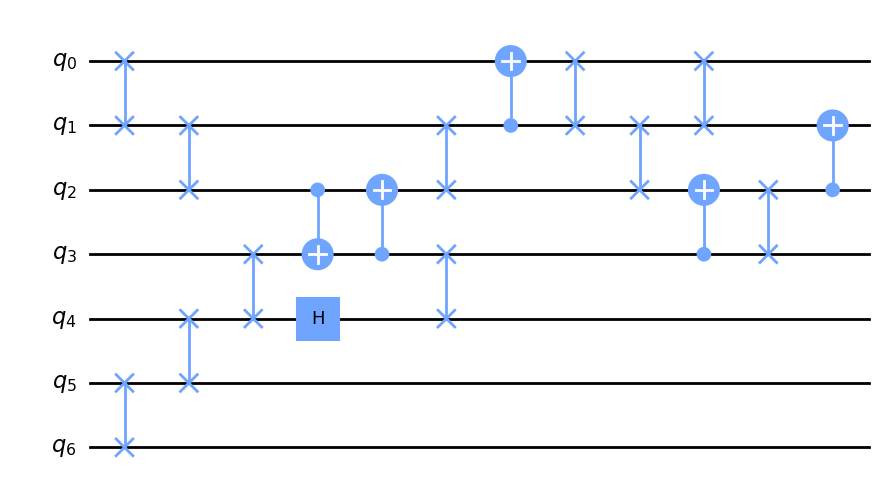

In [9]:
stochastic_circ.draw('mpl')

In [10]:
"""
Preset Pass Managers
    - Several pre-defined pass managers corresponding to various levels of optimization
    - optimization_level 0 through 3 are supported
    - The higher the number, the more optimized it is, at the expense of more time
    - Choosing a good pass manager depends heavily on:
        - The circuit being transpiled
        - The backend being targeted
        - optimization_level = 0
            - Just maps the circuit to the backend, with not explicit optimization
        - optimization_level = 1
            - Maps the circuit, but also does light-weight optimizations by collapsing adjacent gates
        - optimization_level = 2
            - Medium-weight optimization
                - Noise-adaptive layout
                - Gate-cancellation procedure based on gate commutation relationships
        - optimization_level = 3
            - Heavy-weight optimization
            - In addition to previous steps, resynthesizes two-qubit blocks of gates in the circuit
"""
import math
from math import sqrt
from qiskit.providers.fake_provider import FakeTokyo

backend = FakeTokyo()

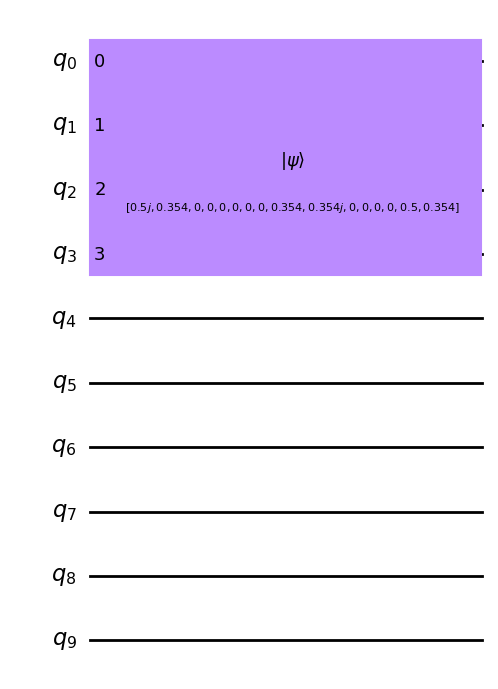

In [11]:
qc = QuantumCircuit(10)

random_state = [
    1/sqrt(4) * complex(0,1),
    1/sqrt(8) * complex(1,0),
    0,
    0,
    0,
    0,
    0,
    0,
    1/sqrt(8) * complex(1,0),
    1/sqrt(8) * complex(0,1),
    0,
    0,
    0,
    0,
    1/sqrt(4) * complex(1,0),
    1/sqrt(8) * complex(1,0)]

qc.initialize(random_state,range(4))
qc.draw('mpl')

In [12]:
#Now map this to the 20-qubit Tokyo devices, with different optimization levels:
optimized_0 = transpile(qc, backend = backend, seed_transpiler = 11, optimization_level = 0)
print('gates =', optimized_0.count_ops())
print('depth =', optimized_0.depth())

gates = OrderedDict([('cx', 70), ('u3', 15), ('u1', 15), ('reset', 4)])
depth = 87


In [13]:
optimized_1 = transpile(qc,backend, seed_transpiler = 11, optimization_level = 1)
print('gates =', optimized_1.count_ops())
print('depth =', optimized_1.depth())

gates = OrderedDict([('cx', 22), ('u3', 15), ('u1', 6)])
depth = 40


In [14]:
optimized_2 = transpile(qc,backend, seed_transpiler = 11, optimization_level = 2)
print('gates =', optimized_2.count_ops())
print('depth =', optimized_2.depth())

gates = OrderedDict([('cx', 20), ('u3', 15), ('u1', 6)])
depth = 38


In [15]:
optimized_3 = transpile(qc,backend, seed_transpiler = 11, optimization_level = 3)
print('gates =', optimized_3.count_ops())
print('depth =', optimized_3.depth())

gates = OrderedDict([('cx', 20), ('u3', 15), ('u1', 6)])
depth = 38


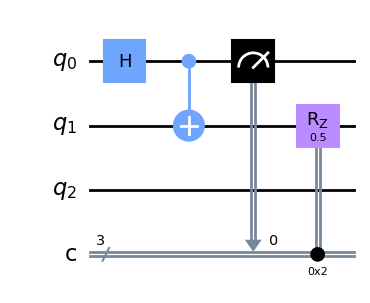

In [16]:
"""
Introducing the Directed Acyclic Graph (DAG)
    - Advantage over pure list of gates: flow of information between operations are explicit
    - makes it easier for passes to make transformation decisions without changing semantics of the circuit
"""
from qiskit import *
from qiskit.dagcircuit import DAGCircuit

q = QuantumRegister(3,'q')
c = ClassicalRegister(3, 'c')
circ = QuantumCircuit(q,c)
circ.h(q[0])
circ.cx(q[0],q[1])
circ.measure(q[0],c[0])
circ.rz(0.5,q[1]).c_if(c,2)
circ.draw('mpl')

In [17]:
import pydot
import graphviz

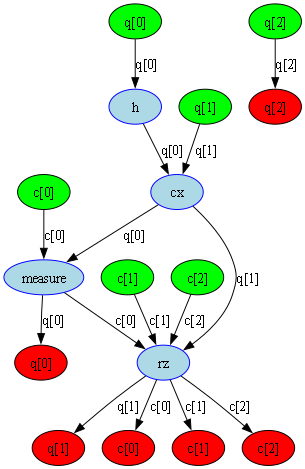

In [18]:
#Three kinds of graph nodes: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red)
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
dag = circuit_to_dag(circ)
dag_drawer(dag)

In [19]:
dag.op_nodes()

[DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), cargs=()),
 DAGOpNode(op=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=(Clbit(ClassicalRegister(3, 'c'), 0),)),
 DAGOpNode(op=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.5]), qargs=(Qubit(QuantumRegister(3, 'q'), 1),), cargs=())]

In [20]:
node = dag.op_nodes()[3]
print('node name: ', node.name)
print('node op: ', node.op)
print('node qargs: ', node.qargs)
print('node cargs: ', node.cargs)
print('node condition: ', node.op.condition)

node name:  rz
node op:  Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.5])
node qargs:  (Qubit(QuantumRegister(3, 'q'), 1),)
node cargs:  ()
node condition:  (ClassicalRegister(3, 'c'), 2)


ValueError: Could not save to JPEG for display

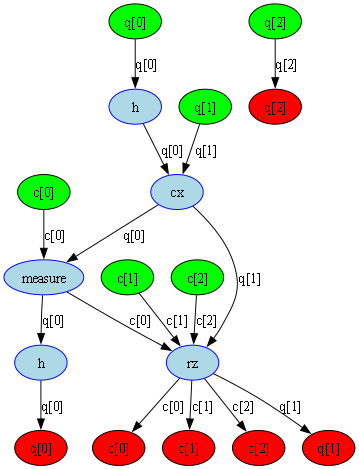

In [21]:
#Add an operation to the back
from qiskit.circuit.library import HGate
dag.apply_operation_back(HGate(), qargs=[q[0]])
dag_drawer(dag)

ValueError: Could not save to JPEG for display

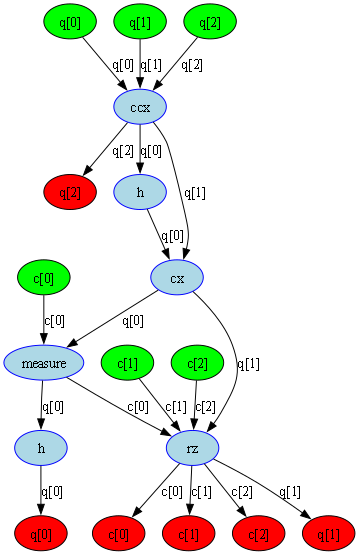

In [22]:
#Add an operation to the front
from qiskit.circuit.library import CCXGate
dag.apply_operation_front(CCXGate(), qargs=[q[0],q[1],q[2]],cargs=[])
dag_drawer(dag)

In [23]:
#Substitute a node with a subcircuit
from qiskit.circuit.library import CHGate, U2Gate, CXGate
mini_dag = DAGCircuit()
p = QuantumRegister(2,'p')
mini_dag.add_qreg(p)
mini_dag.apply_operation_back(CHGate(), qargs = [p[1],p[0]])
mini_dag.apply_operation_back(U2Gate(0.1,0.2), qargs = [p[1]])

#substitute the cx node with the above mini-dag
cx_node = dag.op_nodes(op=CXGate).pop()
dag.substitute_node_with_dag(node=cx_node, input_dag = mini_dag, wires = [p[0],p[1]])

{4: DAGOpNode(op=Instruction(name='ch', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 0)), cargs=()),
 5: DAGOpNode(op=Instruction(name='u2', num_qubits=1, num_clbits=0, params=[0.1, 0.2]), qargs=(Qubit(QuantumRegister(3, 'q'), 1),), cargs=())}

ValueError: Could not save to JPEG for display

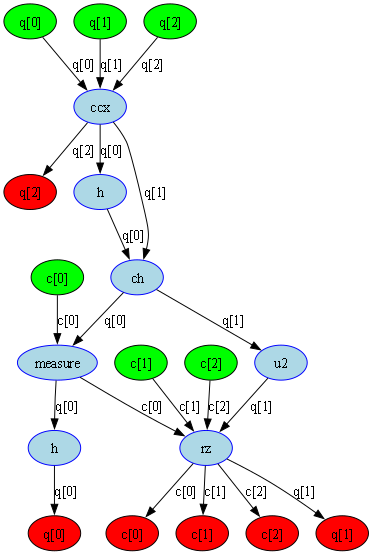

In [24]:
dag_drawer(dag)

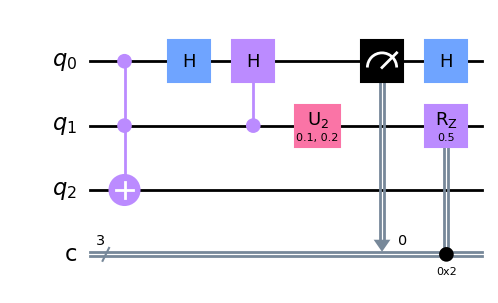

In [25]:
from qiskit.converters import dag_to_circuit
circuit = dag_to_circuit(dag)
circuit.draw('mpl')

In [26]:
"""
Implementing a BasicMapper Pass
- BasicMapper: basic pass for mapping an arbitrary circuit to a device with limited qubit connectivity
- TransofmrationPass: modifies the circuit
- AnalysisPass: only collect information about a circuit (to be used by other passes)
- implement reun(dag) method
- Pass is registered inside the qiskit.transpiler.passes module
"""

from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate

class BasicSwap(TransformationPass):
    #Maps a DAGCircuit onto a 'coupling_map' adding swap gates

    def __init__(self, coupling_map, initial_layout=None):
        """
        Maps a DAGCircuit onto a 'coupling_map' using swap gates
        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map
            initial_layout (Layout): inital layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """
        Runs the BasicSwap pass on 'dag'
        Args:
            dag (DAGCircuit): DAG to map
        Returns:
            TranspilerError: if the coupling map or the layout are not compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)

        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())

        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError('Mappers require to have the layout to be the same size as the coupling map')

        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']
            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    #Insert a new layer with SWAP(s)
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        #create the swap operation
                        swap_layer.apply_operation_back(SwapGate(), qargs=[qubit_1, qubit_2], cargs=[])

                    #Layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits = order)

                    #Update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])
            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits = order)
        return new_dag

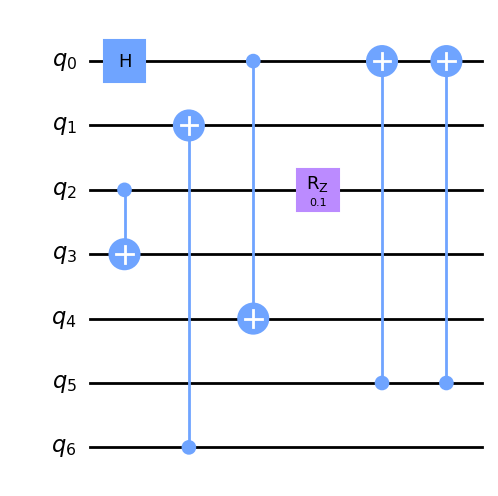

In [27]:
#Test this pass on a small example circuit
q = QuantumRegister(7, 'q')
in_circ = QuantumCircuit(q)
in_circ.h(q[0])
in_circ.cx(q[0],q[4])
in_circ.cx(q[2],q[3])
in_circ.cx(q[6], q[1])
in_circ.cx(q[5],q[0])
in_circ.rz(0.1, q[2])
in_circ.cx(q[5],q[0])
in_circ.draw('mpl')

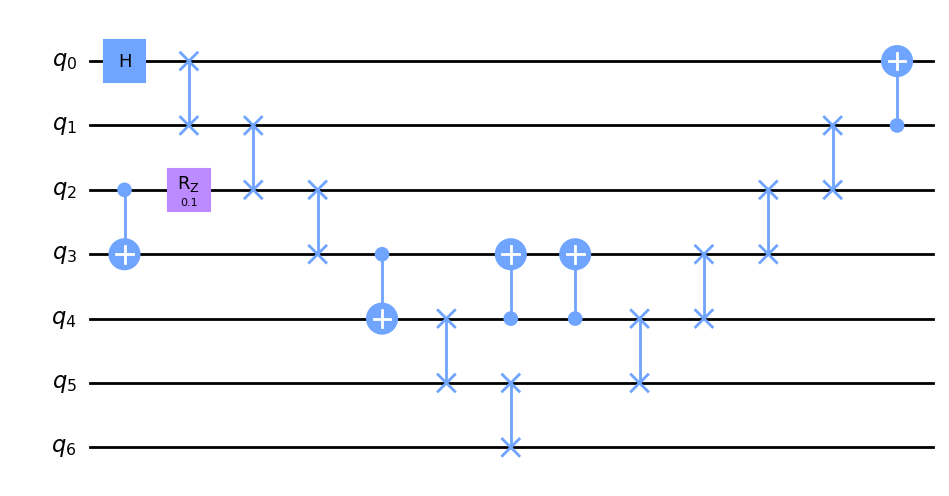

In [28]:
#Now we construct a pass manager that contains our new pass.
pm = PassManager()
coupling = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6]]
coupling_map = CouplingMap(couplinglist = coupling)

pm.append([BasicSwap(coupling_map)])

out_circ = pm.run(in_circ)
out_circ.draw('mpl')

In [30]:
"""
Transpiler Logging
"""
#Configuring Python Standard Library Logging
import logging

logging.basicConfig(level='DEBUG')

In [32]:
from qiskit.providers.fake_provider import FakeTenerife

log_circ = QuantumCircuit(2,2)
log_circ.h(0)
log_circ.h(1)
log_circ.h(1)
log_circ.x(1)
log_circ.cx(0,1)
log_circ.measure([0,1],[0,1])

backend = FakeTenerife()

transpile(log_circ,backend)

DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoin

In [34]:
#Adjusting the log level for the transpiler
logging.getLogger('qiskit.transpiler').setLevel('INFO')
transpile(log_circ,backend)

DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoin

In [37]:
#Setting up logging to deal with parrallel execution
logging.getLogger('qiskit.transpiler').setLevel('DEBUG')

circuits = [log_circ, log_circ]
transpile(circuits,backend)

DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')
DEBUG:stevedore.extension:found extension EntryPoin

In [38]:
formatter = logging.Formatter('%(name)s - %(processName)-10s - %(levelname)s: %(message)s')
handler = logging.getLogger().handlers[0]
handler.setFormatter(formatter)

In [39]:
transpile(circuits,backend)

stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')
stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')
stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')
stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')
stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', g